# **Genomic Data Clustering**

## **Background**

The discovery of DNA (Deoxyribonucleic Acid), and the critical role it plays in information storage for all biological beings, was a seminal moment for the biological sciences. All the information that is needed for the functioning of a living cell is encoded in and ultimately derived from the DNA of that cell, and this holds true for all biological organisms on the planet.

**DNA can be represented as a text sequence, with an alphabet that only has four letters** - A (Adenosine), C (Cytosine), G (Guanine) and T (Thymine). The diversity of living organisms and their complex properties is hidden in their genomic sequences. One of the most exciting problems in modern science is to understand the organization of living matter by reading genomic sequences. 

One distinctive message in a genomic sequence is a piece of text, called a gene. Genes can be oriented in the sequence in either the forward or backward directions. In the highest organisms (humans, for example), the notion of a gene is more complex. 

It was one of the many great discoveries of the Twentieth century, that biological information is encoded in genes by means of **triplets of letters**, **called codons** in the biological literature. 

In this exercise, we will see that it is possible to **verify the validity of the discovery of three-letter codons**, simply by performing unsupervised machine learning on the genetic sequence.

## **Problem Statement**

The work starts with a fragment of the genomic sequence of the bacterium **Caulobacter Crescentus**. This sequence is given as a long text file (300 kb), and the task is to look at the file and ensure that the text uses the alphabet of four letters (A, C, G and T), and that these letters are used without spaces. It is noticeable that, although the text seems to be random, it is well organized, but we cannot understand it without special tools. Statistical methods may help us do so.

In this case study we accept data from a genome and have the goal of identifying useful genes versus noise. Unfortunately, we don't know which sequences of genes are useful, so we have to use Unsupervised Learning to infer this. 

In this notebook we walk through the following series of steps:

  1. First, the data is imported and prepared. Initially the sequence, a single string, is split into non-overlapping substrings of length 300, and we may then count the combinations of the distinct 1, 2, 3, and 4-length sequences of base pairs which appear in each possible substring.
  2. PCA is performed to try to identify the internal structure of the data.
  3. Finally, if PCA reveals some internal structure then we'll apply Clustering techniques to the dataset.

### **Mounting the Drive for Google Colab**
Let us start by mounting the drive and importing the necessary libraries.

In [126]:
# You can uncomment the below code and run the Notebook if it is used in colab
# from google.colab import drive
# drive.mount('/content/drive')

### **Importing the Required Libraries**

In [127]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

### **Data Preparation**


The file format often used for bioinformatics and genomic data is called **FASTA**. It is a normally encoded file with headers separating genetic information. We read the file and strip it of unwanted characters and store it as a string.

In [128]:
# # we open the file and get an array of its lines 
# with open ("ccrescentus.fa", "r") as inputFile:
#     data = inputFile.readlines()

# # we concatenate each line from the second (first line is a description), stripped of empty chars 
# geneticCode = ''
# for line in data[1:]:
#     geneticCode += line.strip()
    
# # we count the presence of each genome(a,g,t,c)
# aCount = geneticCode.count('a')
# gCount = geneticCode.count('g')
# tCount = geneticCode.count('t')
# cCount = geneticCode.count('c')

# # for testing we print a sample of the string and check if there are only wanted characters
# print(geneticCode[0:30])
# print('Test: only a,g,t,c ?')
# print(aCount + gCount + tCount + cCount == len(geneticCode))

In [129]:
# we open the file and concatenate each line from the second (first line is a description), stripped of empty chars
geneticCode = '' 
with open ("ccrescentus.fa", "r") as inputFile:
    for line in inputFile:
        if not line.startswith(">"):
            geneticCode += line.strip()
    
# we count the presence of each genome(a,g,t,c)
aCount = geneticCode.count('a')
gCount = geneticCode.count('g')
tCount = geneticCode.count('t')
cCount = geneticCode.count('c')

# for testing we print a sample of the string and check if there are only wanted characters
print(f"First 30 letters: {geneticCode[0:30]}")
print(f'Only a,g,t,c in code? {aCount + gCount + tCount + cCount == len(geneticCode)}')

First 30 letters: gccgatagcctatgatccccggcaggcccg
Only a,g,t,c in code? True


### **Converting Text to a Numerical Table**

#### **Creating Frequency Tables**
Now we've got a string element containing the sequence. The word is any continuous piece of text that contains several subsequent letters. As there are no spaces in the text, separation into words is not unique. The next step is to separate it into smaller sub-strings and create frequency tables for each x-sized word. We start by separating the string into a number of sub-strings, of a reasonable sample size, to become rows on our table.

**What is a "reasonable size" for a data point?**

Knowing that our string has 30k characters, and that we are checking words with a maximum of 4 - 5 letters, take a size of 300. It generates 1k data points, and allows for 60 5-letter words. It seams reasonable, but do feel free to change it and see the impact. We clip the whole text into fragments of 300 letters 4 in length and calculate the frequencies of short words (of length 1–4) inside every fragment. This will give us a description of the text in the form of a numerical table. There will be four such tables for every short word length choice from 1 to 4. 

As there are only four letters, there are four possible words of length 1 (singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words of length 3 (triplets) and 256 = 4^4 possible words of length 4 (quadruplets). The first table contains four columns (frequency of every singlet) and the number of rows equals the number of fragments. The second table has 16 columns and the same number of rows, and so on. 

In [130]:
# size of the sub strings (data points)
size = 300

# dataPoints = []

# # we copy the entire code into a string, which will removed of its first elements iteratively
# tempString = geneticCode

# # we iteratively remove a left chunk of the string and place it into our array
# while len(tempString) > 0:
#     dataPoints.append(tempString[0:size])
#     tempString = tempString[size:]

# divide the geneticCode string into chunks/slices using list comprehensions
dataPoints = [ geneticCode[i:i+size] for i in range(0, len(geneticCode), size) ]

dataPoints[0]

'gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg'

**Now let's create a list with the combinations of words possible**

In [131]:
# import itertools

# iterables = ['a','g','t','c']
# wordsDict =  {}

# # for words of size 1 to 4, we calculate the cartesian product to get all possibilities
# for i in range(1,5):
#     words = []
#     iterator = itertools.product(iterables, repeat = i)
#     for word in iterator:
#         s = ''
#         for t in word:
#             s += t
#         words.append(s)
#     wordsDict[i] = words

# # print the dictionary for 3 letter words
# print(wordsDict[3])

In [132]:
# More Pythonic version of the previous cell
wordsDict = {}

# For words of size 1 to 4, we calculate the cartesian product to get all possibilities
# as tuples, e.g. ('a','a','a'), then store them as list of strings, e.g. 'aaa'.
for word_size in range(1,5):
    wordsDict[word_size] = [ "".join(word) for word in itertools.product("agtc", repeat=word_size) ]

# print the dictionary for 3 letter words
pprint(wordsDict[3], compact=True)

['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att',
 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg',
 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa',
 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc',
 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt',
 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc']


Now, we create a dataframe to begin the frequency matrix construction. From there, all that we need to do is to apply the count function for each word, and store it as a new column. We do this for all the 4 sizes of words.

In [133]:
# # dictionary that will contain the frequency table for each word size
# freqTables = {}

# for i in range(1,5):
#     # create an empty dataFrame with columns being the words on the dictionary
#     df = pd.DataFrame(columns = wordsDict[i])
#     for index, dataP in enumerate(dataPoints):
#         # we create a row with zero values corresponding to a data point
#         df.loc[index] = np.zeros(len(wordsDict[i]))
#         while len(dataP) > 0:
#             # get the left part of the data point (i characters)
#             left = dataP[0:i]
#             # find it in the respective column and count it there
#             df.loc[index, left] += 1
#             dataP = dataP[i:]
#     freqTables[i] = df

# freqTables[3].head()

In [134]:
# Trying this again being more Pythonic and leveraging Pandas more effectively
# dictionary that will contain the frequency table for each word size
freqTables = {}

for i in range(1,5):
    # create an empty dataFrame with columns being the words on the dictionary
    df = pd.DataFrame(columns = wordsDict[i])
    
    # count the frequences column by column by slicing up each data point into a list of
    # of words, counting the ones that are equal and storing the sums in each column.
    # Requires TWO list comprehensions which is not very readable: one for the list of data points, i.e. dp in ...,
    # another for the slices of each data point, i.e [dp[]...for i in range]. We have to do this because
    # count() can't search substrings in blocks on strings. It searches strings character by character. 
    # We must create a list and ask it to count the matching elements. The code is MUCH faster overall.
    
    for word in wordsDict[i]:
        size = len(word)
        # The slice indices are = range(0, len(dp), size)
        df[word] = [ [ dp[i:i+size] for i in range(0, len(dp), size) ].count(word) for dp in dataPoints ]
    
    freqTables[i] = df

freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0,1,0,3,0,2,0,2,2,0,...,2,2,2,1,1,4,4,4,1,1
1,1,0,0,3,0,1,0,0,5,0,...,2,4,0,2,4,2,1,1,0,1
2,0,1,0,0,0,0,0,0,2,0,...,2,4,0,4,5,4,1,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,4,0,5,5,2,2,0,0,0
4,0,0,0,0,2,0,1,0,0,1,...,2,2,0,8,3,1,5,1,0,0


Now, **we have our data in the optimal format to run PCA.**

### **Principal Component Analysis**

- One reason why we're trying multiple word lengths, is because without additional domain knowledge it is not clear if there are more meaningful units we could work with than individual letters.  
- **So we calculate frequency tables to see if certain combinations happen more frequently (and more frequently together), and thus might be meaningful, than others.**
- PCA helps us by creating natural clusters where combinations frequently co-occur and in reducing the dimensions also enables us to visualize our dataset in a way that's otherwise not possible.

- The first step to run PCA is to **standardize the data** across columns.
- We do this to have the **same averages and dispersions across the data**, which is an important concept of both PCA and K-means, as they are distance-based algorithms.
- The **StandardScaler** package is used to achieve this.

In [135]:

normFreqTables = {}

for i in range(1,5):
    # we eliminate the string column from the data, leaving only the actual frequencies
    data = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(freqTables[i])
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])

# for testing, we check that the average of a column is close to zero and stdev close to 1(i.e. checking for normalization)
print(f"Mean for 'gt' = {normFreqTables[2].loc[:, 'gt'].mean() :0.2}")
print(f"Std dev for 'gt' = {normFreqTables[2].loc[:, 'gt'].std() :.2}")

Mean for 'gt' = -1.1e-16
Std dev for 'gt' = 1.0


In [136]:
pca = PCA(n_components = 2)

pCompTables = {}

for i in range(1,5):
    pComponents = pca.fit_transform(normFreqTables[i])
    # for each word size, we store the result of the PCA in a table containing only the 2 princicipal components
    pCompTables[i] = pd.DataFrame(pComponents[:, [0,1]], columns = ['pc1', 'pc2'])
    print(f'Explained variance for {i} letters: {pca.explained_variance_ratio_.sum():>6.2%}')
    
pCompTables[2].head()

Explained variance for 1 letters: 74.89%
Explained variance for 2 letters: 22.78%
Explained variance for 3 letters: 31.67%
Explained variance for 4 letters:  2.93%


,pc1,pc2
0,-1.024371,-0.308951
1,-0.067967,-0.929419
2,1.107513,0.439177
3,0.580920,1.021940
4,0.079733,1.778117


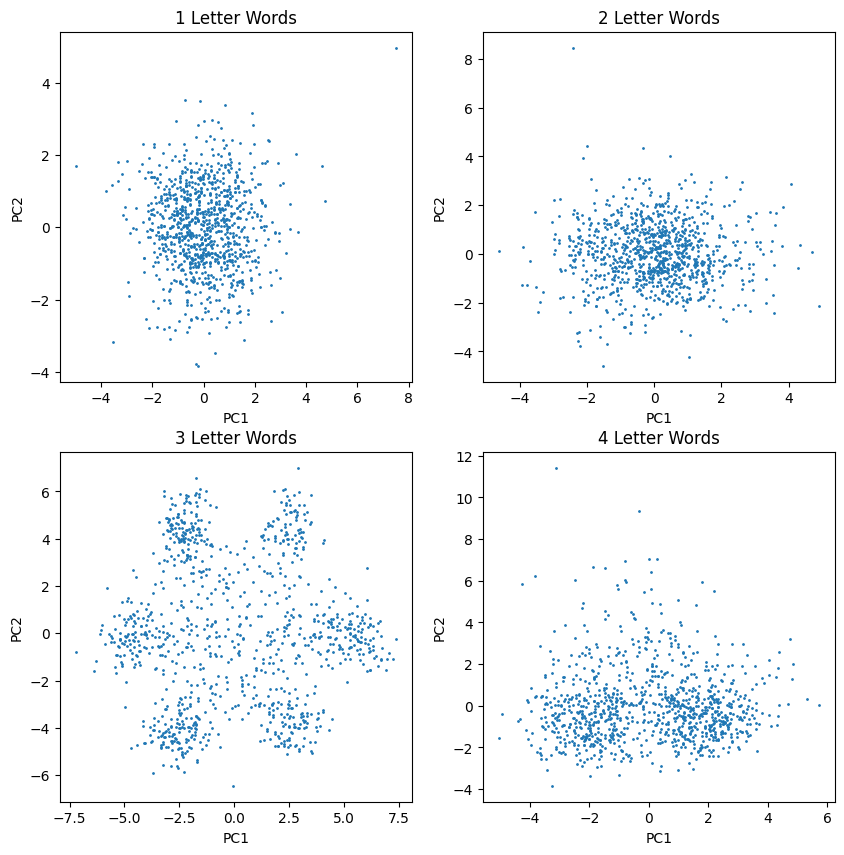

In [137]:
# now we finally need to plot these tables to try to find correlations visually
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(2,2,i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    plt.scatter(x,y, s = 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'{i} Letter Words')

plt.show()

From the plots we can clearly see that **3 letters** generates identifiable visual relations between data points in the first **two principal components**. **These 3 letter words are called codons in biology.**

**What do these point clouds (clusters) mean for the 3-letter words?** 

- We can identify 6 distinct poles, or centroids in the graph. If the genetic information is coded in 3-letter words, each of these clusters has similar distributions of frequencies of these words.

**Why 6 poles then?** 

- Well, since we don't know when a word starts, we can think that if we read the data point with the shift of 1 letter (i.e. not considering the first letter), it would still contain basically the same information. Therefore, in the 3 letter words hypothesis, we can find 3 distinct poles, each representing a shift in reading. The remaining 3 poles are explained since, as the article points out, genetic information is composed of complementary strings (i.e. readable either from left to right or in the opposite way). There are however actually 7 clusters, the last one being the points in the center of the figure, representing the bits of the code that do not carry information.

### **Clustering**
We will now cluster the 3 letter word gene breakdown using the K-means Clustering unsupervised algorithm. From the previous section, we can detect 6 or 7 clusters. Knowing that some genes do not carry information, we are led to think that the center points, far from the 6 distinct centroids, could be a candidate for those. We therefore assume that there are 7 clusters. (this could be checked by comparing the performance of 6 or 7 clustering)

In [138]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(normFreqTables[3])

KMeans(n_clusters=7)

### **Results in a Graph**
Using our clustering results, we can visualize the different colors!

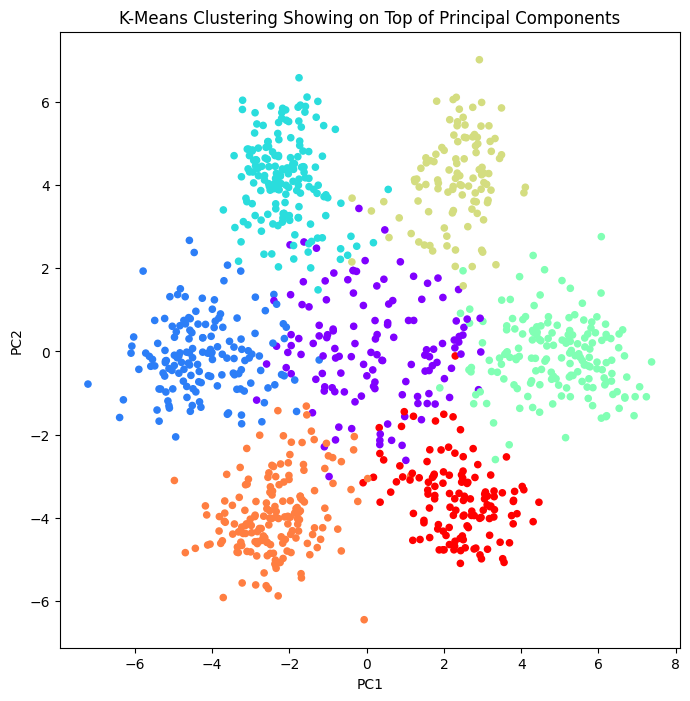

In [139]:
plt.figure(figsize=(8,8))

x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']
# s = dot size, c = color, cmap = color map
plt.scatter(x,y, s = 20, c=kmeans.labels_, cmap = 'rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Showing on Top of Principal Components')

plt.show()

Hence, Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed us to **visualize, validate and provide supporting evidence for the biological discovery** that the DNA genetic sequence is organized into three-letter words called **codons**, which are actually responsible for the amino acids and proteins that are produced by living cells.